## Label drift detector

This notebook follows the example from [river](https://riverml.xyz/0.11.1/examples/concept-drift-detection/).
However, instead of using the river library directly, it detects drift using 
`drifting`. Also, we don't adapt to new domains while serving the detector 
without fitting it again first. 

Let's prepare the data that will imitate the labels

In [1]:
import sys 
sys.path.append("../../") # Adding path to project root for this specific notebook

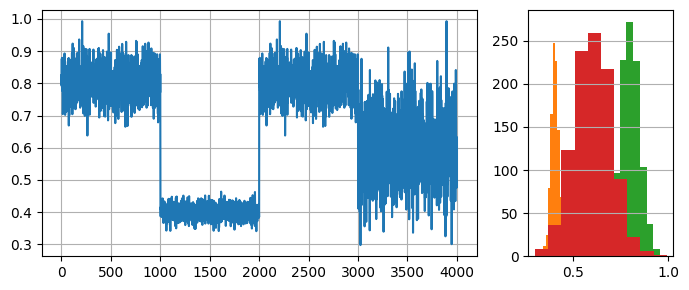

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate data for 3 distributions
random_state = np.random.RandomState(seed=42)
dist_a = random_state.normal(0.8, 0.05, 1000)
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

# Concatenate data to simulate a data stream with 2 drifts
stream = np.concatenate((dist_a, dist_b, dist_a, dist_c))

# Auxiliary function to plot the data
def plot_data(dist_a, dist_b, dist_c, drifts=None, test_stats=None, data_length=None):
    fig = plt.figure(figsize=(7,3), tight_layout=True)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
    ax1.grid()
    ax1.plot(stream, label='Stream')
    ax2.grid(axis='y')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_b, label=r'$dist_b$')
    ax2.hist(dist_a, label=r'$dist_a$')
    ax2.hist(dist_c, label=r'$dist_c$')
    if drifts is not None:

        detections = np.zeros((data_length,))
        detections[drifts] = 1
        ax1.plot(detections, color='red')
    if test_stats is not None:
        ax1.plot(test_stats, color='orange')
    plt.show()

plot_data(dist_a, dist_b, dist_c)


train_data = dist_a
test_data = stream

We can see 3 kinds of predictions. We will fit the drift detector on the first 
distribution, and test it on the two following, putting the training data
in between.

We train the model:

In [3]:

from drifting import DriftingClient, DriftType

client = DriftingClient()
detector_name = "LabelDriftDetector"

In [4]:
client.fit(train_data, drift_type=DriftType.LABEL, detector_name=detector_name, ert=400)

<Response [200]>

Load the model after training:

In [5]:
client.load(detector_name=detector_name)

<Response [200]>

Detect drift sending the labels one by one: 

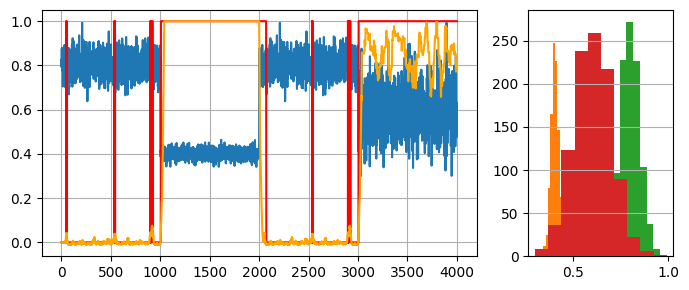

In [6]:

drifts, test_stats = [], []
for i, val in enumerate(test_data):
    val = np.array([val])
    is_drift, test_stat = client.predict(val, drift_type=DriftType.LABEL, detector_name=detector_name)
    # print(response)
    test_stats.append(test_stat)
    if is_drift:
        # The drift detector indicates after each sample if there is a drift in the data
        drifts.append(i)

test_stats = np.array(test_stats) / np.max(test_stats)
plot_data(dist_a, dist_b, dist_c, drifts, test_stats, data_length=len(test_data))

We can see the distributions are differentiated. See other examples for more
real-world use-cases.